In [1]:
import sys 
sys.path.append("../../")

# In[import libs]
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.patches import Arc
from random import randint

from sklearn import metrics 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from data_filters import scout_service as sct
from maths.pitch import dictCoordenadas36, draw_pitch, set_assists_coordinates, set_preassists_coordinates
from maths.pitch import calculate_events_coordinates

from maths.trig import calculate_angles
#from plots import *
from calls import get_jogos_sde

from prettytable import PrettyTable
import math
import time

import gatomestre_sde as sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Retorna informações dos atletas
def get_atletas_sde(atleta_id):
    url = f'/atletas/{atleta_id}'
    try:
        response = sde._request_sde(url, False)
    except:
        url = f'/tecnicos/{atleta_id}'
        try:
            response = sde._request_sde(url, False)
        except:
            return None
    df = pd.DataFrame.from_dict(response).T
    df = sde.pivot_column(df, 'posicao')
    return df

In [3]:
def atualiza_informacoes_atleta(df):
    df_atletas = pd.DataFrame()
    for atleta_id in df['atleta_id'].unique():
        result = get_atletas_sde(int(atleta_id))
        df_atletas = pd.concat([df_atletas, result]).reset_index(drop=True)
    resultado = df.merge(df_atletas, how='left', on='atleta_id')
    return resultado

## Dataset

Dataset é coletado a partir de dados do Scout Service, referentes aos torneios no último biênio (2020/2021):

<code>
torneios = ['AmistososSelecao', 'Baiano', 'Brasileiro', 'BrasileiroB', 'BrasileiroFeminino', 'Carioca', 'CopaAmerica', 
            'CopaBrasil', 'CopaNordeste', 'CopaSPJunior', 'EliminatoriasCopaMundo', 'EuroCopa', 'Gaucho', 'Libertadores', 
            'Mineiro', 'OlimpiadasFutebolFeminino', 'OlimpiadasFutebolMasculino', 'Paulista', 'Pernambucano', 'PreLibertadores', 
            'RecopaSulAmericana', 'SulAmericana', 'SuperCopaBrasil']</code>

In [4]:
# In[Running]
raw = pd.read_csv('database/2023/scout_service/events/Eventos_All.gz',compression='gzip', low_memory=False)
#df.isnull().sum()
# lidar com Nan
raw = raw.fillna(0)
# # limpar colunas
del raw['index']
#del raw['Unnamed: 0']
# dados que precisam ser type <int>
raw = raw.astype({'PosicaoLance': 'int32', 'TempoPartida': 'int32', 'Jogador_Posicao': 'int32', 'atleta_id': 'int32', 'Rodada': 'int32','Codigo':'int32', 'clube_id':'int32','oponente_id':'int32'})
# eliminar lances inexistentes no dataframe
raw = raw[raw['PosicaoLance']!=-1]
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5729431 entries, 0 to 5758178
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Codigo                 int32  
 1   Lance                  object 
 2   Nome                   object 
 3   Ocorrencia             object 
 4   PosicaoLance           int32  
 5   TempoPartida           int32  
 6   TimestampStr           object 
 7   atleta_id              int32  
 8   apelido                object 
 9   sigla                  object 
 10  Jogador_Posicao        int32  
 11  Partida_CodigoExterno  float64
 12  tempo                  object 
 13  tempo_2                object 
 14  clube_id               int32  
 15  Codigo_SCT             float64
 16  Partida_CodigoInterno  float64
 17  Rodada                 int32  
 18  Torneio                object 
 19  Edicao                 float64
 20  oponente_id            int32  
 21  home_dummy             float64
 22  CampoPosicaoX     

In [5]:
raw.head(3)

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,Torneio,Edicao,oponente_id,home_dummy,CampoPosicaoX,CampoPosicaoY,ContraAtaque,Metros,TravePosicaoX,TravePosicaoY
0,74,Passe,Completo,PT26S,13,1,2023-04-15T16:02:10,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74,Passe,Completo,PT35S,19,1,2023-04-15T16:02:18,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74,Passe,Completo,PT7M36S,26,1,2023-04-15T16:09:21,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# verificar se há finalizações na base na rodada atual
print(list(raw['Lance'].unique()))
print(list(raw['Nome'].unique()))


['Passe', 'Não Encontrado', 'Desarme', 'Arbitragem', 'Finalização', 'Falta', 'Drible', 'Goleiro', 'Bloqueio', 'Finalização Cabeça', 'Pênalti', 'Ações Genéricas', 'Equipe']
['Completo', 'Perda de Posse de Bola', 'Desarme', 'Falta Recebida', 'Dentro Área Fora', 'Fora da Área Defendido', 'Incompleto', 'Impedimento', 'Rebatida', 'Falta Cometida', 'Bloqueada', 'Drible Errado', 'Drible Certo', 'Desarme Incompleto', 'Cartão Amarelo', 'Fora', 'Fora da Área Para Fora', 'Dentro Área Defendido', 'Defesa Difícil', 'Defendida', 'Defesa Normal', 'Decisivo', 'Dentro Área Gol', 'Goal Sofrido', 'Fora da Área Bloqueado', 'Bloqueio', 'Dentro Área Trave', 'Grande Área Para Fora', 'Grande Área Gol', 'Dentro Área Bloqueado', 'Grande Área Defendido', 'Grande Área Bloqueado', 'Fora da Área Gol', 'Fora da Área Trave', 'Penalti Recebido', 'Penalti Cometido', 'Gol', 'Cartão Amarelo+Vermelho', 'Defesa de Pênalti', 'Trave', 'Grande Área Trave', 'Cartão Vermelho', 'Gol Contra', 'Finalização Errada', 'Finalização Ce

## Passes completos

In [7]:
print (raw.loc[raw['Nome']=='Completo'])

         Codigo  Lance      Nome Ocorrencia  PosicaoLance  TempoPartida  \
0            74  Passe  Completo      PT26S            13             1   
1            74  Passe  Completo      PT35S            19             1   
2            74  Passe  Completo    PT7M36S            26             1   
3            74  Passe  Completo    PT8M11S            19             1   
8            74  Passe  Completo   PT16M33S            25             1   
...         ...    ...       ...        ...           ...           ...   
5758160      74  Passe  Completo   PT51M12S            24             2   
5758161      74  Passe  Completo   PT51M15S            36             2   
5758166      74  Passe  Completo   PT52M25S            36             2   
5758168      74  Passe  Completo   PT52M30S             9             2   
5758176      74  Passe  Completo   PT54M10S            36             2   

                TimestampStr  atleta_id          apelido sigla  ...  \
0        2023-04-15T16:02:10

## Assistência para Finalização

In [8]:
print (raw.loc[raw['Nome']=='Assistência para Finalização'])

         Codigo           Lance                          Nome Ocorrencia  \
2869926     103  Não Encontrado  Assistência para Finalização   PT48M28S   
2875644     103  Não Encontrado  Assistência para Finalização   PT11M31S   
2875729     103  Não Encontrado  Assistência para Finalização   PT16M19S   
2875795     103  Não Encontrado  Assistência para Finalização   PT21M19S   
2875848     103  Não Encontrado  Assistência para Finalização    PT25M5S   
...         ...             ...                           ...        ...   
5757851     103  Não Encontrado  Assistência para Finalização   PT11M43S   
5757895     103  Não Encontrado  Assistência para Finalização   PT18M19S   
5758100     103  Não Encontrado  Assistência para Finalização   PT45M42S   
5758134     103  Não Encontrado  Assistência para Finalização   PT48M32S   
5758152     103  Não Encontrado  Assistência para Finalização   PT50M34S   

         PosicaoLance  TempoPartida         TimestampStr  atleta_id  \
2869926         

## Passes Decisivos

Asssitencia eram anotadas como Passes decisivos

In [9]:
print (raw.loc[raw['Nome']=='Decisivo'])

         Codigo  Lance      Nome Ocorrencia  PosicaoLance  TempoPartida  \
516          14  Passe  Decisivo   PT44M51S            35             1   
1239         14  Passe  Decisivo    PT3M27S            30             1   
1320         14  Passe  Decisivo   PT14M22S            33             1   
2356         14  Passe  Decisivo   PT42M28S            25             2   
2853         14  Passe  Decisivo   PT35M56S            33             1   
...         ...    ...       ...        ...           ...           ...   
5756872      14  Passe  Decisivo   PT19M38S            34             2   
5756996      14  Passe  Decisivo   PT38M51S            36             2   
5757325      14  Passe  Decisivo   PT13M21S            26             1   
5757424      14  Passe  Decisivo   PT22M51S            25             1   
5757658      14  Passe  Decisivo   PT48M44S            33             1   

                TimestampStr  atleta_id          apelido sigla  ...  \
516      2023-04-15T19:18:00

In [10]:
# padronizar colunas de acordo com pipeline cartola FC
raw = raw.rename(columns={'Jogador_Posicao':'posicao_id',
                         'Rodada':'rodada_id',
                         'oponente_id':'adversario_id',
                         'Partida_CodigoExterno': 'match_id',
                         'Partida_CodigoInterno':'match_id_sct'})

raw = raw.drop_duplicates(keep='last').reset_index(drop=True)
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030817 entries, 0 to 1030816
Data columns (total 28 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Codigo         1030817 non-null  int32  
 1   Lance          1030817 non-null  object 
 2   Nome           1030817 non-null  object 
 3   Ocorrencia     1030817 non-null  object 
 4   PosicaoLance   1030817 non-null  int32  
 5   TempoPartida   1030817 non-null  int32  
 6   TimestampStr   1030817 non-null  object 
 7   atleta_id      1030817 non-null  int32  
 8   apelido        1030817 non-null  object 
 9   sigla          1030817 non-null  object 
 10  posicao_id     1030817 non-null  int32  
 11  match_id       1030817 non-null  float64
 12  tempo          1030817 non-null  object 
 13  tempo_2        1030817 non-null  object 
 14  clube_id       1030817 non-null  int32  
 15  Codigo_SCT     1030817 non-null  float64
 16  match_id_sct   1030817 non-null  float64
 17  rodada_i

# Assistências e Pré-Assistências

- Selecionar assistências (passes decisivos)
- Filtrar passes completos anteriores a cada assistência

In [11]:
def selecionar_assistencias_e_pre_assistencias(df, shot_annotation='Assistência para Finalização'):
    ''''
    Passar shot_annotation ='Decisivo' serve para coletar finalizaçoes passadas,
    já que a nova terminologia é mais recente e tem menor número de ocorrencias
    '''
    assistencias = df.query(f"Nome == 'Decisivo'")
    # lista para armazenar pares de assistência e gol
    result_preassist = []
    for _, assist in assistencias.iterrows():
        # Recuperar os valores para filtrar a pré assistencia
        id_partida_preassist = assist['match_id']
        ocorrencia_preassist = assist['tempo']
        jogador_preassist = assist['atleta_id']
        tempo_preassist = assist['TempoPartida']
        # Filtrar raw com os valores
        preassist_correspondente = df.query("match_id == @id_partida_preassist and tempo < @ocorrencia_preassist and atleta_id != @jogador_preassist and TempoPartida == @tempo_preassist").tail(1)
        # Adicionar a lista caso exista pré-assistencia para aquela assistencia
        if preassist_correspondente['Nome'].values == 'Completo':
            preassist_correspondente['Pre_Assistencia'] = 1
            preassist_correspondente['Assistencia'] = 0
            assist['Pre_Assistencia'] = 0
            assist['Assistencia'] = 1
            result_preassist.append(preassist_correspondente.iloc[0])
            result_preassist.append(assist)
    # DF com as assistências e pré assistencias relacionados
    df_preassist = pd.DataFrame(result_preassist)
    merged = df.merge(df_preassist[['Nome', 'TimestampStr', 'atleta_id', 'match_id', 'Pre_Assistencia', 'Assistencia']], 
                   on=['Nome', 'TimestampStr', 'atleta_id', 'match_id'], 
                   how='left')
    # Replace NaN values with 0
    merged['Pre_Assistencia'].fillna(0, inplace=True)
    merged['Assistencia'].fillna(0, inplace=True)
    # Convert to integer
    merged['Pre_Assistencia'] = merged['Pre_Assistencia'].astype(int)
    merged['Assistencia'] = merged['Assistencia'].astype(int)
    return merged

### Tagear eventos de acordo com goal_id

Cada finalização resultante em gol recebe um id, associado a assistencias e pre assistencias

In [12]:
# def selecionar_eventos(raw):
#     # Cria uma cópia do dataframe para trabalhar
#     df = raw.copy()

#     # Inicializa as colunas de eventos e o ID do gol
#     df['Pre_Assistencia'] = 0
#     df['Assistencia'] = 0
#     df['Finalizacao'] = 0
#     df['goal_id'] = None

#     # Contador para o ID do gol
#     goal_id = 1

    # # Identificar finalizações que resultaram em gol
    # finalizacoes_gol = df[(df['Lance'].isin(['Finalização', 'Finalização Cabeça'])) & 
    #                       (df['Nome'].isin(['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol']))]

#     # Para cada finalização de gol, encontrar a assistência e pré-assistência correspondentes
#     for _, finalizacao in finalizacoes_gol.iterrows():
#         ocorrencia_finalizacao = finalizacao['tempo']
#         tempo_finalizacao = finalizacao['TempoPartida']
#         id_partida = finalizacao['match_id']

#         # Encontrar a assistência
#         assistencia = df.query("match_id == @id_partida and Nome == 'Decisivo' and tempo < @ocorrencia_finalizacao and TempoPartida == @tempo_finalizacao").tail(1)
#         if not assistencia.empty:
#             ocorrencia_assistencia = assistencia['tempo'].iloc[0]
#             tempo_assistencia = assistencia['TempoPartida'].iloc[0]
#             jogador_assistencia = assistencia['atleta_id'].iloc[0]

#             # Encontrar a pré-assistência
#             pre_assistencia = df.query("match_id == @id_partida and atleta_id != @jogador_assistencia and tempo < @ocorrencia_assistencia and TempoPartida == @tempo_assistencia").tail(1)
#             if not pre_assistencia.empty:
#                 df.at[pre_assistencia.index, 'Pre_Assistencia'] = 1
#                 df.at[pre_assistencia.index, 'goal_id'] = goal_id

#             df.at[assistencia.index, 'Assistencia'] = 1
#             df.at[assistencia.index, 'goal_id'] = goal_id

#         # Marcar a finalização e atribuir o ID do gol
#         df.at[finalizacao.name, 'Finalizacao'] = 1
#         df.at[finalizacao.name, 'goal_id'] = goal_id

#         # Incrementar o ID do gol para o próximo gol
#         goal_id += 1

#     # Preencher valores NaN para 'goal_id' com 0
#     df['goal_id'] = df['goal_id'].fillna(0).astype(int)

#     return df


In [13]:
raw_preassist = selecionar_assistencias_e_pre_assistencias(raw, shot_annotation='Decisivo')

In [14]:
raw_preassist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033108 entries, 0 to 1033107
Data columns (total 30 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Codigo           1033108 non-null  int32  
 1   Lance            1033108 non-null  object 
 2   Nome             1033108 non-null  object 
 3   Ocorrencia       1033108 non-null  object 
 4   PosicaoLance     1033108 non-null  int32  
 5   TempoPartida     1033108 non-null  int32  
 6   TimestampStr     1033108 non-null  object 
 7   atleta_id        1033108 non-null  int32  
 8   apelido          1033108 non-null  object 
 9   sigla            1033108 non-null  object 
 10  posicao_id       1033108 non-null  int32  
 11  match_id         1033108 non-null  float64
 12  tempo            1033108 non-null  object 
 13  tempo_2          1033108 non-null  object 
 14  clube_id         1033108 non-null  int32  
 15  Codigo_SCT       1033108 non-null  float64
 16  match_id_sct     1

In [14]:
# raw_preassist[['goal_id','Finalizacao', 'Assistencia', 'Pre_Assistencia']].loc[raw_preassist['goal_id']==3]

,goal_id,Finalizacao,Assistencia,Pre_Assistencia
972,3,1,0,0
626311,3,0,0,1
626313,3,0,1,0


In [15]:
print(set(raw_preassist['Assistencia']))

{0, 1}


### Visualizações

Ver casos em que gols anotados tiveram assistência e pre assistencia

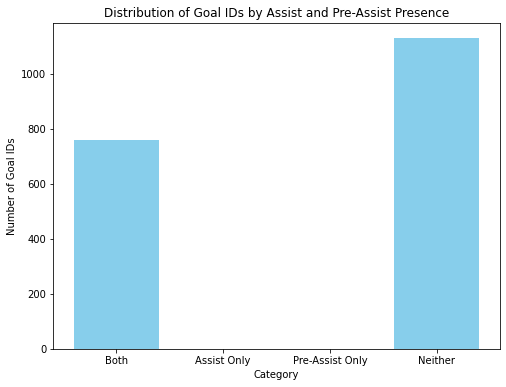

In [15]:
# Agrupando por goal_id e somando as ocorrências de Assistencia e Pre_Assistencia
grouped = raw_preassist.groupby('goal_id').sum()

# Contando quantos goal_ids têm Assistencia e Pre_assistencia correspondentes
with_both = grouped[(grouped['Assistencia'] > 0) & (grouped['Pre_Assistencia'] > 0)].shape[0]
with_assist_only = grouped[(grouped['Assistencia'] > 0) & (grouped['Pre_Assistencia'] == 0)].shape[0]
with_pre_assist_only = grouped[(grouped['Assistencia'] == 0) & (grouped['Pre_Assistencia'] > 0)].shape[0]
with_neither = grouped[(grouped['Assistencia'] == 0) & (grouped['Pre_Assistencia'] == 0)].shape[0]

# Preparando dados para o gráfico
categories = ['Both', 'Assist Only', 'Pre-Assist Only', 'Neither']
counts = [with_both, with_assist_only, with_pre_assist_only, with_neither]

# Plotando o gráfico
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Goal IDs')
plt.title('Distribution of Goal IDs by Assist and Pre-Assist Presence')
plt.show()

## How Do We Calculate Expected Assists?
Stats Perform’s expected assists model is built using a logistic regression model that is powered by hundreds of thousands of passes from our historical Opta data and incorporates a number of variables that affect the likelihood of a given pass becoming an assist, the most important of which are listed below:

- Type of pass​ (e.g., cross, non-cross, header, through ball etc)
- Pattern of play (e.g., open play, corner, free kick, throw-in etc)
- Location of where the pass is received (distancia e angulo da fializacao)
- Location of where pass is made from (distancia e angulo da assistencia)
- Contrataque?


## Transformação das Coordenadas (de assistencias e pre_assistencias, onde não há corrdenada x,y)
#### Recebemos do ScoutService os lances de assistencia posicionados em apenas 36 quadrantes. Precisamos:
- Randomizar as coordenadas (x,y) dentro do quadrante para gerar variância 
- Calcular a distância de cada coordenada em relação ao gol
- Calcular o ângulo (degrees e radians) da coordenada em relação ao gol

In [16]:
# transformar coordenadas centralizadas nos 36 quadrantes em coordenadas (x,y) com variância randomizada
# filtragem por finalizações=
df_events = calculate_events_coordinates(raw_preassist,'xA')
#df_events.to_csv('Events.csv')
print(df_events, df_events.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809460 entries, 0 to 809459
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Codigo                       809460 non-null  int64  
 1   Lance                        809460 non-null  object 
 2   Nome                         809460 non-null  object 
 3   Ocorrencia                   809460 non-null  object 
 4   PosicaoLance                 809460 non-null  int64  
 5   TempoPartida                 809460 non-null  int64  
 6   TimestampStr                 809460 non-null  object 
 7   atleta_id                    809460 non-null  int64  
 8   apelido                      809460 non-null  object 
 9   sigla                        809460 non-null  object 
 10  posicao_id                   809460 non-null  int64  
 11  match_id                     809460 non-null  float64
 12  tempo                        809460 non-null  object 
 13 

In [17]:
print(set(df_events['Assistencia']))

{0, 1}


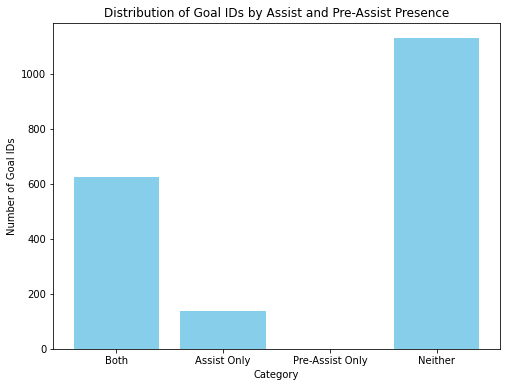

In [17]:
# Agrupando por goal_id e somando as ocorrências de Assistencia e Pre_Assistencia
grouped = df_events.groupby('goal_id').sum()

# Contando quantos goal_ids têm Assistencia e Pre_assistencia correspondentes
with_both = grouped[(grouped['Assistencia'] > 0) & (grouped['Pre_Assistencia'] > 0)].shape[0]
with_assist_only = grouped[(grouped['Assistencia'] > 0) & (grouped['Pre_Assistencia'] == 0)].shape[0]
with_pre_assist_only = grouped[(grouped['Assistencia'] == 0) & (grouped['Pre_Assistencia'] > 0)].shape[0]
with_neither = grouped[(grouped['Assistencia'] == 0) & (grouped['Pre_Assistencia'] == 0)].shape[0]

# Preparando dados para o gráfico
categories = ['Both', 'Assist Only', 'Pre-Assist Only', 'Neither']
counts = [with_both, with_assist_only, with_pre_assist_only, with_neither]

# Plotando o gráfico
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Goal IDs')
plt.title('Distribution of Goal IDs by Assist and Pre-Assist Presence')
plt.show()


<code> x = row['Center_dist_quadrante_event']*.68
y = row['y_quadrante_event']*1.05
row['Distance_quadrante_event'] = np.sqrt(x**2 + y**2)</code>

In [18]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809460 entries, 0 to 809459
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Codigo                       809460 non-null  int64  
 1   Lance                        809460 non-null  object 
 2   Nome                         809460 non-null  object 
 3   Ocorrencia                   809460 non-null  object 
 4   PosicaoLance                 809460 non-null  int64  
 5   TempoPartida                 809460 non-null  int64  
 6   TimestampStr                 809460 non-null  object 
 7   atleta_id                    809460 non-null  int64  
 8   apelido                      809460 non-null  object 
 9   sigla                        809460 non-null  object 
 10  posicao_id                   809460 non-null  int64  
 11  match_id                     809460 non-null  float64
 12  tempo                        809460 non-null  object 
 13 

In [19]:
df_events.head()

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,field_y_px_event,goal_x_metros_event,goal_y_metros_event,field_x_metros_event,field_y_metros_event,Center_dist_event,xA_angle_radians,xA_angle_degrees,xA_vertical_angle_radians,xA_vertical_angle_degrees
0,74,Passe,Completo,PT26S,13,1,2023-04-15T16:02:10,112370,Emerson Negueba,ATA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74,Passe,Completo,PT35S,19,1,2023-04-15T16:02:18,112370,Emerson Negueba,ATA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74,Passe,Completo,PT7M36S,26,1,2023-04-15T16:09:21,112370,Emerson Negueba,ATA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74,Passe,Completo,PT8M11S,19,1,2023-04-15T16:09:55,112370,Emerson Negueba,ATA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74,Passe,Completo,PT16M33S,25,1,2023-04-15T16:18:16,112370,Emerson Negueba,ATA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Finalizações que resultaram em gol
finalizacoes_gol = df_events[(df_events['Lance'].isin(['Finalização', 'Finalização Cabeça'])) & 
                          (df_events['Nome'].isin(['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol']))]
finalizacoes_gol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1917 entries, 114 to 809046
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Codigo                       1917 non-null   int64  
 1   Lance                        1917 non-null   object 
 2   Nome                         1917 non-null   object 
 3   Ocorrencia                   1917 non-null   object 
 4   PosicaoLance                 1917 non-null   int64  
 5   TempoPartida                 1917 non-null   int64  
 6   TimestampStr                 1917 non-null   object 
 7   atleta_id                    1917 non-null   int64  
 8   apelido                      1917 non-null   object 
 9   sigla                        1917 non-null   object 
 10  posicao_id                   1917 non-null   int64  
 11  match_id                     1917 non-null   float64
 12  tempo                        1917 non-null   object 
 13  tempo_2       

In [21]:
# Calcular distância entre passes que precedem finalizações que não resultaram em gol
finalizacoes_nao_gol = df_events[(df_events['Lance'].isin(['Finalização', 'Finalização Cabeça'])) & 
                              (~df_events['Nome'].isin(['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol']))]
finalizacoes_nao_gol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19856 entries, 5 to 809457
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Codigo                       19856 non-null  int64  
 1   Lance                        19856 non-null  object 
 2   Nome                         19856 non-null  object 
 3   Ocorrencia                   19856 non-null  object 
 4   PosicaoLance                 19856 non-null  int64  
 5   TempoPartida                 19856 non-null  int64  
 6   TimestampStr                 19856 non-null  object 
 7   atleta_id                    19856 non-null  int64  
 8   apelido                      19856 non-null  object 
 9   sigla                        19856 non-null  object 
 10  posicao_id                   19856 non-null  int64  
 11  match_id                     19856 non-null  float64
 12  tempo                        19856 non-null  object 
 13  tempo_2        

## Calcular a distancia entre Eventos

In [22]:

# # Function to calculate distance
# def calculate_distance(row1, row2):
#     x1 = row1['Center_dist_quadrante_event'] * 0.68
#     y1 = row1['y_quadrante_event'] * 1.05
#     x2 = row2['Center_dist_quadrante_event'] * 0.68
#     y2 = row2['y_quadrante_event'] * 1.05
#     return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# # Function to calculate distances between specific events
# def calculate_distance_between_events(df):
#     df['Distance_Between_Events'] = np.nan

#     # Finalizações que resultaram em gol
#     finalizacoes_gol = df[(df['Lance'].isin(['Finalização', 'Finalização Cabeça'])) & 
#                           (df['Nome'].isin(['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol']))]

#     # Calcular distância entre Assistência e Finalização
#     for idx, finalizacao in finalizacoes_gol.iterrows():
#         assistencia = df[(df['Assistencia'] == 1) & (df['tempo'] < finalizacao['tempo'])].tail(1)
#         if not assistencia.empty:
#             df.loc[idx, 'Distance_Between_Events'] = calculate_distance(finalizacao, assistencia.iloc[0])

#     # Calcular distância entre Pré-Assistência e Assistência
#     assistencias = df[df['Assistencia'] == 1]
#     for idx, assist in assistencias.iterrows():
#         pre_assist = df[(df['Pre_Assistencia'] == 1) & (df['tempo'] < assist['tempo'])].tail(1)
#         if not pre_assist.empty:
#             df.loc[idx, 'Distance_Between_Events'] = calculate_distance(assist, pre_assist.iloc[0])

#     # Calcular distância entre passes que não resultaram em gol
#     passes = df[(df['Lance'] == 'Passe') & (df['Nome'] == 'Completo')]
#     for idx, passe in passes.iterrows():
#         proximo_passe = df[(df['Lance'] == 'Passe') & (df['Nome'] == 'Completo') & 
#                            (df['tempo'] > passe['tempo'])].head(1)
#         if not proximo_passe.empty:
#             df.loc[idx, 'Distance_Between_Events'] = calculate_distance(passe, proximo_passe.iloc[0])

#     # Preencher NaN com 0
#     df['Distance_Between_Events'].fillna(0, inplace=True)
    
#     return df


def calculate_distance_between_events(df):
    # Pré-filtragem de eventos relevantes
    finalizacoes_gol = df[(df['Lance'].isin(['Finalização', 'Finalização Cabeça'])) & 
                          (df['Nome'].isin(['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol']))]
    assistencias = df[df['Nome'] == 'Assistência para Finalização']
    pre_assistencias = df[df['Nome'] == 'Completo']

    # Inicializando colunas de distância
    df['Distance_Between_Events'] = np.nan

    # Função para calcular a distância
    def calculate_distance(row1, row2):
        return np.abs(row1 - row2)

    # Calcular distâncias para assistências e pré-assistências
    for idx, finalizacao in finalizacoes_gol.iterrows():
        # Assistência mais próxima antes da finalização
        assist_proxima = assistencias[(assistencias['tempo'] < finalizacao['tempo']) &
                                      (assistencias['match_id'] == finalizacao['match_id'])].tail(1)

        if not assist_proxima.empty:
            df.at[idx, 'Distance_Between_Events'] = calculate_distance(
                finalizacao['Center_dist_event'], assist_proxima['Center_dist_event'].iloc[0])

        # Pré-assistência mais próxima antes da assistência
        if not assist_proxima.empty:
            pre_assist_proxima = pre_assistencias[(pre_assistencias['tempo'] < assist_proxima['tempo'].iloc[0]) &
                                                  (pre_assistencias['match_id'] == assist_proxima['match_id'].iloc[0])].tail(1)

            if not pre_assist_proxima.empty:
                df.at[assist_proxima.index[0], 'Distance_Between_Events'] = calculate_distance(
                    assist_proxima['Center_dist_event'].iloc[0], pre_assist_proxima['Center_dist_event'].iloc[0])

    # Preencher NaN com 0
    df['Distance_Between_Events'].fillna(0, inplace=True)

    return df

In [23]:
df_events_distance = calculate_distance_between_events(df_events)

In [24]:
df_events_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809460 entries, 0 to 809459
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Codigo                       809460 non-null  int64  
 1   Lance                        809460 non-null  object 
 2   Nome                         809460 non-null  object 
 3   Ocorrencia                   809460 non-null  object 
 4   PosicaoLance                 809460 non-null  int64  
 5   TempoPartida                 809460 non-null  int64  
 6   TimestampStr                 809460 non-null  object 
 7   atleta_id                    809460 non-null  int64  
 8   apelido                      809460 non-null  object 
 9   sigla                        809460 non-null  object 
 10  posicao_id                   809460 non-null  int64  
 11  match_id                     809460 non-null  float64
 12  tempo                        809460 non-null  object 
 13 

In [25]:
df_training = df_events_distance.copy()

In [26]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809460 entries, 0 to 809459
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Codigo                       809460 non-null  int64  
 1   Lance                        809460 non-null  object 
 2   Nome                         809460 non-null  object 
 3   Ocorrencia                   809460 non-null  object 
 4   PosicaoLance                 809460 non-null  int64  
 5   TempoPartida                 809460 non-null  int64  
 6   TimestampStr                 809460 non-null  object 
 7   atleta_id                    809460 non-null  int64  
 8   apelido                      809460 non-null  object 
 9   sigla                        809460 non-null  object 
 10  posicao_id                   809460 non-null  int64  
 11  match_id                     809460 non-null  float64
 12  tempo                        809460 non-null  object 
 13 

In [27]:
set(df_training['Assistencia'])

{0, 1}

In [36]:
print ("Rows     : " ,df_training.shape[0])
print ("Columns  : " ,df_training.shape[1])
print ("\nFeatures : \n" ,df_training.columns.tolist())
print ("\nUnique values :  \n",df_training.nunique())
print ("\nMissing values :  ", df_training.isnull().sum().values.sum())

Rows     :  809462
Columns  :  55

Features : 
 ['Codigo', 'Lance', 'Nome', 'Ocorrencia', 'PosicaoLance', 'TempoPartida', 'TimestampStr', 'atleta_id', 'apelido', 'sigla', 'posicao_id', 'match_id', 'tempo', 'tempo_2', 'clube_id', 'Codigo_SCT', 'match_id_sct', 'rodada_id', 'Torneio', 'Edicao', 'adversario_id', 'home_dummy', 'CampoPosicaoX', 'CampoPosicaoY', 'ContraAtaque', 'Metros', 'TravePosicaoX', 'TravePosicaoY', 'Pre_Assistencia', 'Assistencia', 'Goal', 'header', 'coordenadas_event', 'x_quadrante_event', 'y_quadrante_event', 'X_quadrante_event', 'Y_quadrante_event', 'Center_dist_quadrante_event', 'Distance_quadrante_event', 'angle_radians_event', 'angle_degrees_event', 'goal_x_px_event', 'goal_y_px_event', 'field_x_px_event', 'field_y_px_event', 'goal_x_metros_event', 'goal_y_metros_event', 'field_x_metros_event', 'field_y_metros_event', 'Center_dist_event', 'xA_angle_radians', 'xA_angle_degrees', 'xA_vertical_angle_radians', 'xA_vertical_angle_degrees', 'Distance_Between_Events']

U

## Features

- Type of pass​ (e.g., cross, non-cross, header, through ball etc)
- Pattern of play (e.g., open play, corner, free kick, throw-in etc)
- Location of where the pass is received 
- Location of where pass is made from
- Distance of the pass
-------------------------------------------------------------------
- xA_angle_degrees (angulo da finalizacao)
- angle_degrees_event (angulo do passe)
- Center_dist_event (distancia finalizacao pelas novas coordenadas)
- Center_dist_quadrante_event (distancia fializacao e passes pela antiga coordenadas)
- Distance_Between_Events (distancia entre passes ou entre passe e finalizacao)

## Avaliação de outros modelos

- SVM
- KNN
- Naive Bayes
- Logistic Regression

Vamos criar um método que recebe um modelo com uma série de parametrizações e procede com Validação Cruzada para cada um desses modelos, de modo a atingirmos a otimização ideal, evitando overfitting nos dados de treinamento e nos dados de teste

In [29]:
def avaliar_modelos(tipo, parametrizacoes, X, y, resultados):

    """Avalia modelos utilizando 10-fold cross-validation

    Essa função recebe um conjunto de parametrizações, um conjunto de 
    atributos e labels e popula uma estrutura de resultados.    
    """
    # Vamos iterar sobre cada parametrização no dicionário.
    # Ao adicionar .items(), vamos iterar sobre todos os pares
    # (chave, valor) do dicionário:
    for nome, modelo in parametrizacoes.items():
        seed = 0
        np.random.seed(seed)
        print("Avaliando parametrização:", nome)
        print("\tProgresso: [", end = '')
        # Vamos padronizar nossos dados com o StandardScaler
        #scaler = StandardScaler()
        # StratifiedKFold irá separar nossos dados em K splits estratificados,
        # ou seja, K splits onde a distribuição das classes será igual ao dos
        # dados originais. Shuffle irá embaralhar nossos dados antes de efetuar
        # o split.
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        # As 3 listas a seguir irão armazenar as métricas de acurácia, recall e
        # área sob a curva ROC de cada fold. Usaremos essas listas para calcular
        # a média de cada métrica.
        accs_scores = []
        recall_scores = []        
        roc_aucs_scores = []
        precision_scores = []
        # O método split irá retornar índices que nós usaremos pra indexar os
        # conjuntos X e y. Por exemplo, se tivermos 10 exemplos no nosso conjunto
        # de dados e quisermos realizar 5 splits, uma possível divisão de splits
        # seria [1, 2], [0, 3], [4, 9], [5, 8], [6, 7]. Então para cada iteração
        # do for, o método split separa 1 desses splits para treino e o resto 
        # para teste (ex. teste = [1, 2], treino = [0, 3, 4, 9, 5, 8, 6, 7]). O 
        # loop for acaba depois que todos os splits forem usados para teste.        
        for treino, teste in cv.split(X, y):
            # Fit do modelo nos dados de treino:
            modelo.fit(X[treino], y[treino])
            # Calculo das métricas do fold. Armazenamos elas nas listas que
            # definimos anteriormente.
            y_pred = modelo.predict(X[teste])                    
            accs_scores.append(accuracy_score(y[teste], y_pred))
            recall_scores.append(recall_score(y[teste], y_pred, average=None))
            precision_scores.append(precision_score(y[teste], y_pred))
            # y_score calculado como especificado em:
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            y_score = modelo.predict_proba(X[teste])[:, 1]
            roc_aucs_scores.append(roc_auc_score(y[teste], y_score))
            # Barra de progresso             
            print("#", end = '')
        print("]")
        # Adicionando média dos folds aos resultados:
        resultados['Algoritmo'].append(tipo)
        resultados["Parametrização"].append(nome)
        resultados["Acuracia"].append(np.mean(accs_scores))
        resultados["Precisao"].append(np.mean(precision_scores)) 
        resultados["Recall"].append(np.mean(recall_scores))
        resultados["Roc_auc"].append(np.mean(roc_aucs_scores))

### Parâmetros

Introduzimos X e y no método <code>avaliar_modelos()</code>, com um dicionário que, para cada modelo, vai avaliar:

- Parametrização
- Acuracia
- Recall
- Roc_auc

In [30]:
X = df_training[['xA_angle_degrees', 'Center_dist_event','Center_dist_quadrante_event', 'Distance_Between_Events','header','ContraAtaque']].copy().values
y = df_training[['Assistencia']].values.reshape(-1)


print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Precisao":[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # definindo as diferentes configurações para o método SVC
# modelos_svm = {
#     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
#     "Kernel linear": SVC(kernel = 'linear', probability=True),
#     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
#     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
#     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# }

# # avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)

# # definindo as diferentes configurações para o método NB
# modelos_gaussian = {
#     "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
#     "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
#     "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
#     "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
#     "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
# }

# avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# # definindo as diferentes configurações para o método KNN

# modelos_knn = {
#     "N=3": KNeighborsClassifier(n_neighbors=3),
#     "N=5": KNeighborsClassifier(n_neighbors=5),
#     "N=7": KNeighborsClassifier(n_neighbors=7),
#     "N=9": KNeighborsClassifier(n_neighbors=9),
#     "N=11": KNeighborsClassifier(n_neighbors=11),
# }

# avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(809460, 6)
(809460,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [###

In [18]:
X = df_training[['xA_angle_degrees', 'Center_dist_event','Center_dist_quadrante_event', 'Distance_Between_Events','header','ContraAtaque']].copy().values
y = df_training[['Pre_Assistencia']].values.reshape(-1)


print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # # definindo as diferentes configurações para o método SVC
# # modelos_svm = {
# #     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
# #     "Kernel linear": SVC(kernel = 'linear', probability=True),
# #     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
# #     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
# #     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# # }

# # avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)

# # definindo as diferentes configurações para o método NB
# modelos_gaussian = {
#     "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
#     "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
#     "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
#     "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
#     "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
# }

# avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# # definindo as diferentes configurações para o método KNN

# modelos_knn = {
#     "N=3": KNeighborsClassifier(n_neighbors=3),
#     "N=5": KNeighborsClassifier(n_neighbors=5),
#     "N=7": KNeighborsClassifier(n_neighbors=7),
#     "N=9": KNeighborsClassifier(n_neighbors=9),
#     "N=11": KNeighborsClassifier(n_neighbors=11),
# }

# avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(219818, 2)
(219818,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [##########]
Avaliando parametrização: XGBoost with max_depth=3, learning_rate=0.1
	Progresso: [##########]
Avaliando parametrização: XGBoost with subsample=0.7, colsample_bytree=0.8
	Progresso: [##########]
Avaliando parametrização: XGBoost with scale_pos_weight for imbalanced
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-9
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-8
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-7
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-6
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-5
	Progresso: [##########]
Avaliando parametr

{'Algoritmo': ['Logistic Regression',
  'Logistic Regression',
  'Logistic Regression',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'KNN',
  'KNN',
  'KNN',
  'KNN',
  'KNN'],
 'Parametrização': ['Logistic Regression',
  'Logistic Regression, fit_intercetp=False',
  'Logistic Regression, Weights Balanced',
  'XGBoost Default',
  'XGBoost with max_depth=3, learning_rate=0.1',
  'XGBoost with subsample=0.7, colsample_bytree=0.8',
  'XGBoost with scale_pos_weight for imbalanced',
  'Var smoothing 1e-9',
  'Var smoothing 1e-8',
  'Var smoothing 1e-7',
  'Var smoothing 1e-6',
  'Var smoothing 1e-5',
  'N=3',
  'N=5',
  'N=7',
  'N=9',
  'N=11'],
 'Acuracia': [0.9980847792672087,
  0.9980847792672087,
  0.6211501998539519,
  0.9980847792672087,
  0.9980847792672087,
  0.9980847792672087,
  0.9980301887341014,
  0.9920343180975095,
  0.9920479656273067,
  0.992179892783476,
  0.9933990834947897,
  0.9963

In [31]:
# resultados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Precisao,Roc_auc
0,Logistic Regression,Logistic Regression,0.997155,0.500000,0.000000,0.513489
1,Logistic Regression,"Logistic Regression, fit_intercetp=False",0.997151,0.499998,0.000000,0.513485
2,Logistic Regression,"Logistic Regression, Weights Balanced",0.029742,0.513487,0.002924,0.513485


In [32]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["Roc_auc"].agg([ ("Roc_auc", max)])
best_roc_aucs

,Roc_auc
Algoritmo,
Logistic Regression,0.513489


In [33]:
melhores_parametrizacoes = {}
for linha in best_roc_aucs.itertuples():
    print(linha)
    tipo_algo = linha[0]
    melhor_valor = linha[1]    
    # Colocamos iloc[0] no final para pegar a primeira ocorrencia, pois podemos
    # ter mais de uma mesma parametrização com mesmo valor roc_aoc:
    melhores_parametrizacoes[tipo_algo] = resultados_df.query(
        "(Algoritmo==@tipo_algo) & (Roc_auc==@melhor_valor)").iloc[0]["Parametrização"]
    
    print("Melhor parametrização do", tipo_algo, "=", melhores_parametrizacoes[tipo_algo])

    # parâmetros dos melhores modelos
melhor_logis_regression = modelos_logis_regression[melhores_parametrizacoes["Logistic Regression"]]
# melhor_gaussiannb = modelos_gaussian[melhores_parametrizacoes["GaussianNB"]]
# melhor_KNN = modelos_knn[melhores_parametrizacoes["KNN"]]
melhor_xgboost = modelos_xgboost[melhores_parametrizacoes["XGBoost"]]

Pandas(Index='Logistic Regression', Roc_auc=0.5134886690358667)
Melhor parametrização do Logistic Regression = Logistic Regression


NameError: name 'modelos_xgboost' is not defined

## Modelo Escolhido - Logistic Regression
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False

## O vetor xA e XPre

Criemos um método que recebe o dataset de finalizações para treino e teste. Este método aceita filtragem por campeonato.

In [26]:
def logistic_regression_xA(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset
    dataset = df[['Assistencia', 'Distance Assist','Angle Radians Assist']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Assistencia',axis=1), 
                                                        dataset['Assistencia'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')

    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:,1]
    # para obter probabilidades de todas as linhas do dataset
    y_hat = logistic_model.predict_proba(dataset.drop('Assistencia',axis=1))[:,1]
    y_hat.shape
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xA'] = y_hat
    return df

In [32]:
def logistic_regression_xPre(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset
    dataset = df[['Pre_Assistencia', 'Distance PreAssist','Angle Radians PreAssist']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Pre_Assistencia',axis=1), 
                                                        dataset['Pre_Assistencia'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')

    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:,1]
    # para obter probabilidades de todas as linhas do dataset
    y_hat = logistic_model.predict_proba(dataset.drop('Pre_Assistencia',axis=1))[:,1]
    y_hat.shape
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xPre'] = y_hat
    return df

In [28]:
# def xgboost_xA(df=None, torneio=None, edicao=None, filtrar=False):
#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     # Inicializar o dataset
#     dataset = df[['Assistencia', 'Distance Assist','Angle Radians Assist']].copy()

#     # Dividir em treino e teste
#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Assistencia', axis=1), dataset['Assistencia'], test_size=0.20, random_state=10)

#     # Inicializar o modelo XGBoost
#     xgb_model = XGBClassifier()

#     # Treinar o modelo
#     xgb_model.fit(X_train, y_train)

#     # Fazer previsões no conjunto de teste
#     y_pred = xgb_model.predict(X_test)

#     # Avaliar a precisão do modelo
#     accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy:", accuracy)

#     # Fazer previsões no conjunto completo
#     y_probs = xgb_model.predict_proba(dataset.drop('Assistencia', axis=1))[:, 1]

#     # Adicionar probabilidades xG ao DataFrame original
#     df['xA'] = y_probs

#     return df

######################################################################################################################################################

# def xgboost_xA(df=None, torneio=None, edicao=None, filtrar=False):

#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     dataset = df[['Assistencia', 'Distance Assist','Angle Radians Assist']].copy()
#     dataset['Distance*Angle_assist'] = dataset['Distance Assist'] * dataset['Angle Radians Assist']

#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Assistencia', axis=1), dataset['Assistencia'], test_size=0.20, random_state=10)

#     xgb_model = XGBClassifier()
#     xgb_model.fit(X_train, y_train)

#     calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
#     calibrated_clf.fit(X_train, y_train)

#     y_pred = xgb_model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
#     auc = roc_auc_score(y_test, y_pred)

#     print("Accuracy:", accuracy)
#     print("Log Loss:", logloss)
#     print("AUC:", auc)

#     y_probs = calibrated_clf.predict_proba(dataset.drop('Assistencia', axis=1))[:, 1]
#     df['xA'] = y_probs

#     return df

######################################################################################################################################################
######################################################################################################################################################

def xgboost_xPre(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

    # Inicializar o dataset
    dataset = df[['Pre_Assistencia', 'Distance PreAssist','Angle Radians PreAssist']].copy()

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Pre_Assistencia', axis=1), dataset['Pre_Assistencia'], test_size=0.20, random_state=10)

    # Inicializar o modelo XGBoost
    xgb_model = XGBClassifier()

    # Treinar o modelo
    xgb_model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = xgb_model.predict(X_test)

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Fazer previsões no conjunto completo
    y_probs = xgb_model.predict_proba(dataset.drop('Assistencia', axis=1))[:, 1]

    # Adicionar probabilidades xG ao DataFrame original
    df['xA'] = y_probs

    return df

######################################################################################################################################################

# def xgboost_xPre(df=None, torneio=None, edicao=None, filtrar=False):

#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     dataset = df[['Pre_Assistencia', 'Distance PreAssist','Angle Radians PreAssist']].copy()
#     dataset['Distance Assist*Angle Radians Assist'] = dataset['Distance Assist'] * dataset['Angle Radians Assist']

#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Pre_Assistencia', axis=1), dataset['Pre_Assistencia'], test_size=0.20, random_state=10)

#     xgb_model = XGBClassifier()
#     xgb_model.fit(X_train, y_train)

#     calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
#     calibrated_clf.fit(X_train, y_train)

#     y_pred = xgb_model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
#     auc = roc_auc_score(y_test, y_pred)

#     print("Accuracy:", accuracy)
#     print("Log Loss:", logloss)
#     print("AUC:", auc)

#     y_probs = calibrated_clf.predict_proba(dataset.drop('Pre_Assistencia', axis=1))[:, 1]
#     df['xPre'] = y_probs

#     return df


## Opções de treinamento

#### Podemos:

- Treinar o modelo apenas com dados de um torneio desejado, usando um método que recebe torneio
- Treinar o modelo com todos os torneios, e filtrar apenas o vetor do recorte desejado. Por ora, seguimos com esta opção

In [52]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
df_geral = logistic_regression_xA(df=df_assists_on_pitch)
#df_geral = xgboost_xA(df=df_assists_on_pitch)

# filtrar apenas lances do campeonato brasileiro
df_brasileiro_assists = df_geral.loc[(df_assists_on_pitch['Torneio']=='Brasileiro')&(df_assists_on_pitch['Edicao']==2023)]

In [53]:
print (df_brasileiro_assists.info(),df_brasileiro_assists)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 123076 to 355171
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Codigo                347 non-null    int64  
 1   Lance                 347 non-null    object 
 2   Nome                  347 non-null    object 
 3   Ocorrencia            347 non-null    object 
 4   PosicaoLance          347 non-null    int64  
 5   TempoPartida          347 non-null    int64  
 6   TimestampStr          347 non-null    object 
 7   atleta_id             347 non-null    int64  
 8   apelido               347 non-null    object 
 9   sigla                 347 non-null    object 
 10  posicao_id            347 non-null    int64  
 11  match_id              347 non-null    float64
 12  tempo                 347 non-null    object 
 13  tempo_2               347 non-null    object 
 14  clube_id              347 non-null    int64  
 15  Codigo_SCT     

In [54]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
#df_geral = logistic_regression_xPre(df=df_preassists_on_pitch)
df_geral = xgboost_xA(df=df_assists_on_pitch)

# filtrar apenas lances do campeonato brasileiro
df_brasileiro_preassists = df_geral.loc[(df_preassists_on_pitch['Torneio']=='Brasileiro')&(df_preassists_on_pitch['Edicao']==2023)]

In [55]:
print (df_brasileiro_preassists.info(),df_brasileiro_preassists)

# df_brasileiro = atualiza_informacoes_atleta(df_brasileiro)
# print (df_brasileiro.info(),df_brasileiro)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 145094 entries, 122919 to 355319
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Codigo                   145094 non-null  int64  
 1   Lance                    145094 non-null  object 
 2   Nome                     145094 non-null  object 
 3   Ocorrencia               145094 non-null  object 
 4   PosicaoLance             145094 non-null  int64  
 5   TempoPartida             145094 non-null  int64  
 6   TimestampStr             145094 non-null  object 
 7   atleta_id                145094 non-null  int64  
 8   apelido                  145094 non-null  object 
 9   sigla                    145094 non-null  object 
 10  posicao_id               145094 non-null  int64  
 11  match_id                 145094 non-null  float64
 12  tempo                    145094 non-null  object 
 13  tempo_2                  145094 non-null  object 
 14 

In [56]:
df_brasileiro_assists = df_brasileiro_assists.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             
df_brasileiro_assists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 123076 to 355171
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Codigo                347 non-null    int64  
 1   Lance                 347 non-null    object 
 2   Nome                  347 non-null    object 
 3   Ocorrencia            347 non-null    object 
 4   PosicaoLance          347 non-null    int64  
 5   TempoPartida          347 non-null    int64  
 6   TimestampStr          347 non-null    object 
 7   atleta_id             347 non-null    int64  
 8   apelido               347 non-null    object 
 9   sigla                 347 non-null    object 
 10  posicao_id            347 non-null    int64  
 11  match_id              347 non-null    float64
 12  tempo                 347 non-null    object 
 13  tempo_2               347 non-null    object 
 14  clube_id              347 non-null    int64  
 15  Codigo_SCT     

In [57]:
df_brasileiro_preassists = df_brasileiro_preassists.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             
df_brasileiro_preassists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145094 entries, 122919 to 355319
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Codigo                   145094 non-null  int64  
 1   Lance                    145094 non-null  object 
 2   Nome                     145094 non-null  object 
 3   Ocorrencia               145094 non-null  object 
 4   PosicaoLance             145094 non-null  int64  
 5   TempoPartida             145094 non-null  int64  
 6   TimestampStr             145094 non-null  object 
 7   atleta_id                145094 non-null  int64  
 8   apelido                  145094 non-null  object 
 9   sigla                    145094 non-null  object 
 10  posicao_id               145094 non-null  int64  
 11  match_id                 145094 non-null  float64
 12  tempo                    145094 non-null  object 
 13  tempo_2                  145094 non-null  object 
 14 

In [58]:
df_brasileiro_assists['apelido']

123076               Dudu
123677      Jonathan Cafu
123890          Vanderlan
124296           Thaciano
124297           Thaciano
               ...       
353496        Victor Hugo
353724    Sebastián Gómez
354268        Luiz Araújo
354682           Canobbio
355171           Vinicius
Name: apelido, Length: 347, dtype: object

## Agrupamentos, Agregações e Análises

Agora podemos começar a calcular o XG em razão de time, posição, temporada etc

In [59]:
df_brasileiro_assists.groupby('clube_id')['rodada_id'].unique().count()
rodada = df_brasileiro_assists['rodada_id'].max()
print(rodada)

20


In [60]:
df_brasileiro_assists['rodada_id'].nunique()

20

In [39]:
df_brasileiro_assists[df_brasileiro_assists['clube_id']==262]['rodada_id'].nunique()

20

### Trazer Dataset Cartola

In [61]:
# base cartola
#file_name = '/Volumes/Dados/Documents/Code/Apps/gitlab/conteudo/calculadora_gm_backend/calculadora-gato-mestre-backend/database/2022/Cartola_2022_Individual'

file_name = 'database/2023/Cartola_2023_Individual'
df_cartola = pd.read_csv(file_name, compression='gzip', low_memory=False)

# file_name2 = 'Cartola_2022_Individual'
# df_cartola = pd.read_csv(file_name2, compression='gzip', low_memory=False)
# df_cartola.to_csv('Cartola_2022_chat')


In [62]:
df_cartola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14804 entries, 0 to 14803
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nome               14804 non-null  object 
 1   slug               14804 non-null  object 
 2   apelido            14804 non-null  object 
 3   atleta_id          14804 non-null  int64  
 4   rodada_id          14804 non-null  int64  
 5   clube_id           14804 non-null  int64  
 6   posicao_id         14804 non-null  int64  
 7   status_id          14804 non-null  int64  
 8   pontos_num         14804 non-null  float64
 9   preco_num          14804 non-null  float64
 10  variacao_num       14804 non-null  float64
 11  media_num          14804 non-null  float64
 12  jogos_num          14804 non-null  int64  
 13  clube              14804 non-null  object 
 14  posicao            14804 non-null  object 
 15  status_pre         14804 non-null  object 
 16  FF                 148

In [63]:
df_cartola['rodada_id'].nunique()

20

In [64]:
times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
             'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
            'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
            'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

times_dict_r = {v:k for k, v in times_dict.items()}
clubes_ids = list(times_dict.values())

team_icons = {
'Internacional':'![Internacional](https://s.glbimg.com/es/sde/f/organizacoes/2016/05/03/inter65.png)',
'Santos':'![Santos](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/santos_60x60.png)',
'Bragantino':'![Bragantino](https://s.glbimg.com/es/sde/f/organizacoes/2020/01/01/65.png)',
'Flamengo':'![Flamengo](https://s.glbimg.com/es/sde/f/organizacoes/2018/04/09/Flamengo-65.png)',
'Fortaleza':'![Fortaleza](https://s.glbimg.com/es/sde/f/organizacoes/2018/06/10/fortaleza-ec-65px.png)',
'Fluminense':'![Fluminense](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/fluminense_60x60.png)',
'Palmeiras':'![Palmeiras](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/palmeiras_60x60.png)',
'Athlético-PR':'![Athlético-PR](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png)',
'Atlético-MG':'![Atlético-MG](https://s.glbimg.com/es/sde/f/organizacoes/2017/11/23/Atletico-Mineiro-escudo65px.png)',
'Corinthians':'![Corinthians](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/30/Corinthians_65.png)',    
'São Paulo':'![São Paulo](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/sao_paulo_60x60.png)',
'América-MG':' ![América-MG](https://s.glbimg.com/es/sde/f/organizacoes/2019/02/28/escudo65_1.png)',
'Cuiabá':' ![Cuiabá](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/16/cuiaba65.png)',
'Coritiba':'![Coritiba](https://s.glbimg.com/es/sde/f/organizacoes/2017/03/29/coritiba65.png)',
'Goiás':'![Goiás](https://s.glbimg.com/es/sde/f/organizacoes/2019/05/01/Goias_65px.png)',
'Botafogo':'![Botafogo](https://s.glbimg.com/es/sde/f/equipes/2013/12/16/botafogo_30x30.png)',
'Grêmio':'![Grêmio](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/gremio_60x60.png)',
'Vasco':'![Vasco](https://s.glbimg.com/es/sde/f/organizacoes/2016/07/29/Vasco-65.png)',
'Bahia':'![Bahia](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/bahia_60x60.png)',
'Cruzeiro':'![Cruzeiro](https://s.sde.globo.com/media/organizations/2021/02/13/cruzeiro_2021.svg)'
        }

### Trazer mando de campo a partir das partidas

In [65]:
# df_merge = df_brasileiro.merge(df_cartola, on='match_id', how='inner')
# df_merge.info()

# xA Clubes
Calcular o xA agregado por clubes.

- somar o xA total
- somar o xA por partida
- calcular a média por partida
- comparar total vs média

In [66]:
# xG total
df_clubes_xa_total = df_brasileiro_assists.groupby(['clube_id'])['xA'].agg([('xA_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xa_match = df_brasileiro_assists.groupby(['clube_id','rodada_id'])['xA'].agg([('xA_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xa_mean = df_clubes_xa_match.groupby('clube_id')['xA_sum'].agg([('xA_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xa_std = df_brasileiro_assists.groupby('clube_id')['xA'].agg([('xA_std',np.std)]).reset_index()
# gols
df_clubes_a_total = df_cartola.groupby('clube_id')['A'].agg([('A_total','sum')]).reset_index()
# merge
df_clubes_xa = df_clubes_xa_total.merge(df_clubes_xa_mean, on='clube_id')
# merge again
df_clubes_xa_vs_a = df_clubes_xa.merge(df_clubes_a_total, on='clube_id')
# and again
df_clubes_xa_vs_a = df_clubes_xa_vs_a.merge(df_clubes_xa_std, on='clube_id')
#print(df_clubes_xg_vs_g)
# equipes por strings
df_clubes_xa_vs_a['clube'] = df_clubes_xa_vs_a['clube_id'].map(times_dict_r)
df_clubes_xa_vs_a['clube'] = df_clubes_xa_vs_a['clube'].map(team_icons)
# sort por média xG
df_clubes_xa_vs_a = df_clubes_xa_vs_a.sort_values(by='xA_total',ascending=False).reset_index(drop=True)[['clube', 'xA_mean', 'xA_total','A_total']]
df_clubes_xa_vs_a.dropna()

#df_clubes_xa_vs_a.to_csv(f'conteudo/xA_vs_A_R{rodada}.csv', index=False)

df_clubes_xa_vs_a

,clube,xA_mean,xA_total,A_total
0,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.301517,19.522762,27.0
1,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.404352,18.256575,23.0
2,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,1.035326,16.565215,22.0
3,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.170677,16.389477,23.0
4,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.163478,15.125214,19.0
5,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,1.726726,13.813812,14.0
6,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.124709,13.496505,20.0
7,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.123609,13.483313,20.0
8,![Fluminense](https://s.glbimg.com/es/sde/f/or...,0.970558,11.646700,17.0
9,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,0.950884,11.410612,14.0


## XPre CLubes

In [67]:
# xG total
df_clubes_xpre_total = df_brasileiro_preassists.groupby(['clube_id'])['xPre'].agg([('xPre_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xpre_match = df_brasileiro_preassists.groupby(['clube_id','rodada_id'])['xPre'].agg([('xPre_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xpre_mean = df_clubes_xpre_match.groupby('clube_id')['xPre_sum'].agg([('xPre_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xpre_std = df_brasileiro_preassists.groupby('clube_id')['xPre'].agg([('xPre_std',np.std)]).reset_index()
# gols
# Merging summary statistics dataframes based on 'clube_id'
df_merged = df_clubes_xpre_total.merge(df_clubes_xpre_mean, on='clube_id', how='outer')
df_merged = df_merged.merge(df_clubes_xpre_std, on='clube_id', how='outer')

# equipes por strings
df_merged['clube'] = df_merged['clube_id'].map(times_dict_r)
df_merged['clube'] = df_merged['clube'].map(team_icons)
# sort por média xG
df_merged = df_merged.sort_values(by='xPre_total',ascending=False).reset_index(drop=True)[['clube', 'xPre_mean', 'xPre_total']]
df_merged.dropna()

#df_clubes_xa_vs_a.to_csv(f'conteudo/xA_vs_A_R{rodada}.csv', index=False)

df_merged

,clube,xPre_mean,xPre_total
0,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.383697,27.673936
1,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.255640,25.112807
2,![Fluminense](https://s.glbimg.com/es/sde/f/or...,1.188323,23.766461
3,![Internacional](https://s.glbimg.com/es/sde/f...,1.037361,20.747215
4,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,1.020401,20.408025
5,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.071552,20.359488
6,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,1.000819,20.016380
7,![Cruzeiro](https://s.sde.globo.com/media/orga...,0.991987,19.839735
8,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,0.982219,19.644381
9,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.015033,19.285632


# xA Atletas

#### Agora vamos fazer o cálculo de xG etc sob a perspectiva dos atletas

- Estudo 01. xA total
- Estudo 02. xA por jogo
- Estudo 03. xA vs gols
- Estudo 04. xA como medida de eficiência
- Estudo 05. xA como medida de potencial

## xA Total

In [68]:
df_atletas = df_brasileiro_assists.groupby(['atleta_id', 'apelido','clube_id'])['xA'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xA',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xA']]
df_atletas.head(30)

,apelido,clube_id,clube,xA
0,Thaciano,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,5.829166
1,Alisson,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,3.993415
2,Arrascaeta,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,3.475846
3,Lucas Evangelista,280,![Bragantino](https://s.glbimg.com/es/sde/f/or...,3.435789
4,Gerson,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,3.145884
5,Tiquinho Soares,263,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,2.869833
6,Pavón,282,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,2.819528
7,Eduardo,263,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,2.771944
8,Soteldo,277,![Santos](https://s.glbimg.com/es/sde/f/organi...,2.764555
9,Cauly,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,2.761855


## XPre total

In [69]:
df_atletas = df_brasileiro_preassists.groupby(['atleta_id', 'apelido','clube_id'])['xPre'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xPre',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xPre']]
df_atletas.head(30)

,apelido,clube_id,clube,xPre
0,Cauly,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,3.919398
1,Arias,266,![Fluminense](https://s.glbimg.com/es/sde/f/or...,3.466419
2,Marlon,283,![Cruzeiro](https://s.sde.globo.com/media/orga...,3.270251
3,Caio Paulista,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,2.995867
4,Bruno Rodrigues,283,![Cruzeiro](https://s.sde.globo.com/media/orga...,2.883196
5,Reinaldo,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,2.835048
6,Lucas Piton,267,![Vasco](https://s.glbimg.com/es/sde/f/organiz...,2.827441
7,Sander,290,![Goiás](https://s.glbimg.com/es/sde/f/organiz...,2.790133
8,Bitello,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,2.736613
9,Gerson,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,2.713885


## Adiconar métricas 

- xG_per_match
- xG_per_shot
- shots_per_goal

In [377]:
df_atletas2 = df_brasileiro.groupby(['atleta_id', 'apelido', 'clube_id']).agg(xG_total=('xG', 'sum'),
                                                                             shots_total=('Lance', 'count'),
                                                                             jogos_num=('rodada_id', 'nunique'),
                                                                             goals_total=('Goal', 'sum')).reset_index()
df_atletas2['xG_per_match']=df_atletas2['xG_total']/df_atletas2['jogos_num']
df_atletas2['G_per_match']=df_atletas2['goals_total']/df_atletas2['jogos_num']
df_atletas2['xG_per_shot'] = df_atletas2['xG_total']/df_atletas2['shots_total']
df_atletas2['shots_per_goal'] = df_atletas2['shots_total']/df_atletas2['goals_total']
df_atletas2['clube'] = df_atletas2['clube_id'].map(times_dict_r)
df_atletas2['clube'] = df_atletas2['clube'].map(team_icons)

xg_total = df_atletas2.sort_values(by='xG_total',ascending=False).reset_index(drop=True)

#df_atletas2 = df_atletas2[df_atletas2['clube_id'].isin(clubes_ids)].sort_values(by='xG_total',ascending=False).reset_index(drop=True)

xg_total.head(50)

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,83257,Gabriel,262,3.216875,23,7,3,0.459554,0.428571,0.139864,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
1,61188,Gilberto,283,2.801841,22,8,3,0.350230,0.375000,0.127356,7.333333,![Cruzeiro](https://s.sde.globo.com/media/orga...
2,89898,Róger Guedes,264,2.724498,29,7,4,0.389214,0.571429,0.093948,7.250000,![Corinthians](https://s.glbimg.com/es/sde/f/o...
3,73850,Aloísio,327,2.677313,23,7,3,0.382473,0.428571,0.116405,7.666667,![América-MG](https://s.glbimg.com/es/sde/f/o...
4,87470,Thaciano,265,2.626094,30,6,2,0.437682,0.333333,0.087536,15.000000,![Bahia](https://s.glbimg.com/es/sde/f/organiz...
5,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
6,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
7,101002,Júnior Santos,263,2.459331,22,8,2,0.307416,0.250000,0.111788,11.000000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
8,39148,Hulk,282,2.398085,30,8,4,0.299761,0.500000,0.079936,7.500000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
9,92811,Bruno Rodrigues,283,2.199849,25,8,2,0.274981,0.250000,0.087994,12.500000,![Cruzeiro](https://s.sde.globo.com/media/orga...


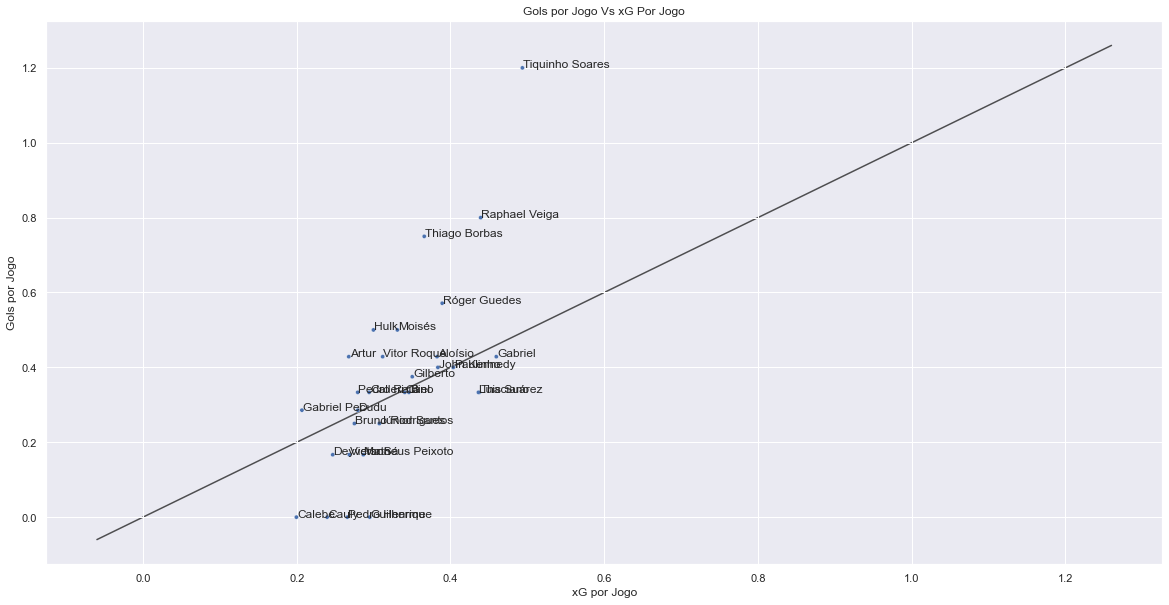

In [378]:
def xG_fit(df,rodada):
    # pegar apenas 30
    df = df.head(30)
    # # obter médias para o tracejado nos eixos
    # xG_geral_mean = np.mean(list(df['xG_geral'].values))
    # xGA_geral_mean = np.mean(list(df['xGA_geral'].values))
    
    #sns.set_theme()
    
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))

    p1 = sns.scatterplot('xG_per_match', # Horizontal axis
       'G_per_match', # Vertical axis
       data=df, # Data source
       size = 8,
       legend=False) 
    
    
    plt.title('Gols por Jogo Vs xG Por Jogo')
    # Set x-axis label
    plt.xlabel('xG por Jogo')
    # Set y-axis label
    plt.ylabel('Gols por Jogo')
    
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.001, point['y'], str(point['val']))
            #ax.plot([-1,1],[-1,1], 'red', linewidth=10)

            
    label_point(df.xG_per_match, df.G_per_match, df.apelido, plt.gca())  

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    #ax.set_aspect('equal')
    # ax.set_xlim(lims)
    # ax.set_ylim(lims)
    
    fig.savefig(f'img/G_vs_xG_fit_atletas{rodada}.png')
    
xG_fit(xg_total,rodada)

## xG per match

In [379]:
rodada = df_brasileiro['rodada_id'].max()
PORCENTAGEM_MINIMA_JOGOS = 2.5  # 40%
min_jogos = rodada // PORCENTAGEM_MINIMA_JOGOS
print(min_jogos)

mask = (xg_total['jogos_num']>=int(min_jogos))
xg_per_match = xg_total.loc[mask]
xg_per_match = xg_per_match.sort_values(by='xG_per_match',ascending=False).reset_index(drop=True)

xg_per_match.head(20)

3.0


,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,83257,Gabriel,262,3.216875,23,7,3,0.459554,0.428571,0.139864,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
2,93108,Mateus Vital,283,1.333061,12,3,0,0.444354,0.000000,0.111088,inf,![Cruzeiro](https://s.sde.globo.com/media/orga...
3,94509,Raphael Veiga,275,2.196487,23,5,4,0.439297,0.800000,0.095499,5.750000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
4,87470,Thaciano,265,2.626094,30,6,2,0.437682,0.333333,0.087536,15.000000,![Bahia](https://s.glbimg.com/es/sde/f/organiz...
5,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
6,124251,Deivid Washington,277,1.241499,12,3,2,0.413833,0.666667,0.103458,6.000000,![Santos](https://s.glbimg.com/es/sde/f/organi...
7,99818,Paulinho,282,2.018075,14,5,2,0.403615,0.400000,0.144148,7.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
8,98022,Erick,293,1.192451,10,3,0,0.397484,0.000000,0.119245,inf,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
9,89898,Róger Guedes,264,2.724498,29,7,4,0.389214,0.571429,0.093948,7.250000,![Corinthians](https://s.glbimg.com/es/sde/f/o...


In [380]:
xg_per_match = xg_per_match[['apelido','clube','xG_per_match','G_per_match']]
xg_per_match.head(20).to_csv(f'conteudo/xG_ate_R{rodada}.csv', index=False)



## xG vs Gols

Um estudo comparativo entre Gols e Expected Gols pode ser visto sob dois prismas:

- Eficiência
- Potencial

### 'Eficiência' mede, a partir da diferença entre uma métrica e outra, o nível de aproveitamento dos atletas.

In [381]:
df_atletas2['eficiência'] = df_atletas2['goals_total']-df_atletas2['xG_total']
df_eficiencia = df_atletas2.loc[df_atletas2['goals_total']>=1].sort_values(by='eficiência',ascending=False).reset_index(drop=True).head(50)
df_eficiencia.dropna()

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,3.532174
1,84817,Robson,294,0.585521,5,4,3,0.146380,0.750000,0.117104,1.666667,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,2.414479
2,94509,Raphael Veiga,275,2.196487,23,5,4,0.439297,0.800000,0.095499,5.750000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.803513
3,115959,Endrick,275,1.197232,9,5,3,0.239446,0.600000,0.133026,3.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.802768
4,70360,Eduardo Sasha,280,1.276931,10,7,3,0.182419,0.428571,0.127693,3.333333,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.723069
5,91706,Marlon,283,0.291919,3,2,2,0.145959,1.000000,0.097306,1.500000,![Cruzeiro](https://s.sde.globo.com/media/orga...,1.708081
6,113359,Pablo Maia,276,0.394424,9,6,2,0.065737,0.333333,0.043825,4.500000,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.605576
7,39148,Hulk,282,2.398085,30,8,4,0.299761,0.500000,0.079936,7.500000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,1.601915
8,83528,Léo Pereira,262,0.451552,4,3,2,0.150517,0.666667,0.112888,2.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.548448
9,117314,Thiago Borbas,280,1.463322,8,4,3,0.365831,0.750000,0.182915,2.666667,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.536678


In [382]:
df_eficiencia = df_eficiencia[['apelido','clube','xG_total','goals_total','xG_per_match','G_per_match','shots_per_goal']]
df_eficiencia.head(20).to_csv(f'conteudo/Eficiencia_ate_R{rodada}.csv', index=False)
df_eficiencia

,apelido,clube,xG_total,goals_total,xG_per_match,G_per_match,shots_per_goal
0,Tiquinho Soares,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,2.467826,6,0.493565,1.200000,3.500000
1,Robson,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,0.585521,3,0.146380,0.750000,1.666667
2,Raphael Veiga,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,2.196487,4,0.439297,0.800000,5.750000
3,Endrick,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.197232,3,0.239446,0.600000,3.000000
4,Eduardo Sasha,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.276931,3,0.182419,0.428571,3.333333
5,Marlon,![Cruzeiro](https://s.sde.globo.com/media/orga...,0.291919,2,0.145959,1.000000,1.500000
6,Pablo Maia,![São Paulo](https://s.glbimg.com/es/sde/f/org...,0.394424,2,0.065737,0.333333,4.500000
7,Hulk,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,2.398085,4,0.299761,0.500000,7.500000
8,Léo Pereira,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.451552,2,0.150517,0.666667,2.000000
9,Thiago Borbas,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.463322,3,0.365831,0.750000,2.666667


### 'Potencial' mede, por outro lado, aqueles atletas que tem maior potencial de crescimento
Se invertermos o ranking, vemos quem está no topo do aproveitamente abaixo do esperado, ou seja, com maiores possibilidades de convergência para a expectativa

In [383]:
# note: ascending = True
df_potencial = df_atletas2.loc[df_atletas2['goals_total']>=1].head(20).sort_values(by='eficiência',ascending=True).reset_index(drop=True)
df_potencial

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,-0.618237
1,69138,Pablo,293,1.005802,16,7,1,0.143686,0.142857,0.062863,16.000000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,-0.005802
2,68920,Dudu,275,1.956005,22,7,2,0.279429,0.285714,0.088909,11.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,0.043995
3,61188,Gilberto,283,2.801841,22,8,3,0.350230,0.375000,0.127356,7.333333,![Cruzeiro](https://s.sde.globo.com/media/orga...,0.198159
4,73850,Aloísio,327,2.677313,23,7,3,0.382473,0.428571,0.116405,7.666667,![América-MG](https://s.glbimg.com/es/sde/f/o...,0.322687
5,69102,Vargas,282,0.510632,4,2,1,0.255316,0.500000,0.127658,4.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,0.489368
6,52827,David Luiz,262,0.362464,4,3,1,0.120821,0.333333,0.090616,4.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.637536
7,70666,Marllon,1371,0.327906,4,3,1,0.109302,0.333333,0.081977,4.000000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...,0.672094
8,51042,Apodi,290,0.278492,3,2,1,0.139246,0.500000,0.092831,3.000000,![Goiás](https://s.glbimg.com/es/sde/f/organiz...,0.721508
9,51772,Everton Ribeiro,262,0.277240,5,3,1,0.092413,0.333333,0.055448,5.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.722760


In [210]:
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 2257681 to 2304742
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Codigo         1096 non-null   int64  
 1   Lance          1096 non-null   object 
 2   Nome           1096 non-null   object 
 3   Ocorrencia     1096 non-null   object 
 4   PosicaoLance   1096 non-null   int64  
 5   TempoPartida   1096 non-null   int64  
 6   TimestampStr   1096 non-null   object 
 7   atleta_id      1096 non-null   int64  
 8   apelido        1096 non-null   object 
 9   sigla          1096 non-null   object 
 10  posicao_id     1096 non-null   int64  
 11  match_id       1096 non-null   float64
 12  tempo          1096 non-null   object 
 13  tempo_2        1096 non-null   object 
 14  clube_id       1096 non-null   int64  
 15  Codigo_SCT     1096 non-null   float64
 16  match_id_sct   1096 non-null   float64
 17  rodada_id      1096 non-null   int64  
 18 

In [ ]:
# def xG_geral(df, row):
#     # Geral
#     conquistado_geral = df[(df['rodada_id']<=row['rodada_id']) & \
#                            (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_geral[0]

# def xG_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     conquistado_mandante_posicao = df[(df['home_dummy']==1) & \
#                                       (df['clube_id']==row['clube_id']) & \
#                                       (df['rodada_id']<=row['rodada_id']) & \
#                                       (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_mandante_geral = df[(df['home_dummy']==1) & \
#                                     (df['rodada_id']<=row['rodada_id']) & \
#                                     (df['clube_id']==row['clube_id'])][['xG']].mean()
#     # Visitante
#     # Posicao
#     conquistado_visitante_posicao = df[(df['home_dummy']==0) & \
#                                        (df['clube_id']==row['clube_id']) & \
#                                        (df['rodada_id']<=row['rodada_id']) & \
#                                        (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_visitante_geral = df[(df['home_dummy']==0) & \
#                                      (df['rodada_id']<=row['rodada_id']) & \
#                                      (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_mandante_posicao[0], conquistado_mandante_geral[0], conquistado_visitante_posicao[0], conquistado_visitante_geral[0]

# # xG allowed
# def xGA_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     cedido_mandante_posicao = df[(df['home_dummy']==0) & \
#                                  (df['adversario_id']==row['equipe_id']) & \
#                                  (df['rodada_id']<=row['rodada_id']) & \
#                                  (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_mandante_geral = df[(df['home_dummy']==0) & \
#                                (df['rodada_id']<=row['rodada_id']) & \
#                                (df['adversario_id']==row['equipe_id'])][['xG']].mean()

#     # Visitante
#     # Posicao
#     cedido_visitante_posicao = df[(df['home_dummy']==1) & \
#                                   (df['adversario_id']==row['equipe_id']) & \
#                                   (df['rodada_id']<=row['rodada_id']) & \
#                                   (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_visitante_geral = df[(df['home_dummy']==1) & \
#                                 (df['rodada_id']<=row['rodada_id']) & \
#                                 (df['adversario_id']==row['equipe_id'])][['xG']].mean()


#     return cedido_mandante_posicao[0], cedido_mandante_geral[0], cedido_visitante_posicao[0], cedido_visitante_geral[0]

# df_brasileiro['xg_mando_pos'] = df_brasileiro.apply(lambda x: xG_mando_posicao(df_brasileiro, x))
# #print (df_brasileiro.query('rodada_id >= 1')[('sum', 'xG')].mean())